In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import torch
import copy
import os
import re
%matplotlib inline

!pip install timm flash_attn einops
!pip install ultralytics

  Using cached timm-1.0.8-py3-none-any.whl.metadata (53 kB)
  Using cached flash_attn-2.6.3.tar.gz (2.6 MB)
  Preparing metadata (setup.py) ... done
  Using cached einops-0.8.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu1

In [2]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
import zipfile
from torch.cuda.amp import autocast

In [3]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
def run_example(task_prompt, image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [10]:
# Unzip the archive in Colab's file system
zip_path = '/content/drive/MyDrive/archive.zip'
extract_path = '/content/archive'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Directory containing the images
image_dir = extract_path

In [11]:
# Directory containing the images
image_dir = os.path.join(extract_path, 'flickr30k_images', 'flickr30k_images')

# Verify that this directory exists and contains images
if os.path.isdir(image_dir):
    print(f"Image directory exists: {image_dir}")
    print(f"Number of files in directory: {len(os.listdir(image_dir))}")
else:
    print(f"Image directory does not exist: {image_dir}")

Image directory exists: /content/archive/flickr30k_images/flickr30k_images
Number of files in directory: 31785


In [12]:
res = pd.read_csv('/content/drive/My Drive/results.csv', sep='|')
res.columns = res.columns.str.strip()
res.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [13]:
def get_pet_images(res, total_images):
  """
  Extracts the specified number of unique image names from the DataFrame based on categories,
  ensuring samples do not exceed available images, and adds a 'class' column with value 'pet'.

  Args:
    res: The DataFrame containing image names and comments.
    total_images: The desired total number of images.

  Returns:
    A DataFrame with 'image_name' and 'class' columns.
  """

  cat_rows = res[res['comment'].str.contains('kitten|cat ', case=False, na=True)]
  num_cats = min(len(cat_rows), total_images)  # Limit to available cats

  puppy_rows = res[res['comment'].str.contains('puppy|puppies', case=False, na=True)]
  puppy_rows = puppy_rows[~puppy_rows['image_name'].isin(cat_rows['image_name'])]  # Remove overlaps
  num_puppies = min(100, len(puppy_rows))  # Limit to 100 puppies

  remaining_images = total_images - num_cats - num_puppies

  dog_rows = res[res['comment'].str.contains(' dog | dogs ', case=False, na=True)]
  dog_rows = dog_rows[~dog_rows['image_name'].isin(cat_rows['image_name'])]  # Remove cat overlaps
  dog_rows = dog_rows[~dog_rows['image_name'].isin(puppy_rows['image_name'])]  # Remove puppy overlaps
  num_dogs = min(remaining_images, len(dog_rows))

  cat_sample = cat_rows.sample(num_cats)
  puppy_sample = puppy_rows.sample(num_puppies)
  dog_sample = dog_rows.sample(num_dogs)

  all_images = pd.concat([cat_sample, puppy_sample, dog_sample])
  all_images['class'] = 'pet'

  return all_images


In [14]:
def get_person_images(res, total_images):
  """
  Extracts the specified number of unique image names from the DataFrame based on categories,
  ensuring samples do not exceed available images, and adds a 'class' column with value 'person'.

  Args:
    res: The DataFrame containing image names and comments.
    total_images: The desired total number of images.

  Returns:
    A DataFrame with 'image_name' and 'class' columns.
  """

  limit = total_images/4

  men_rows = res[res['comment'].str.contains(' men | man ', case=False, na=True)]
  num_men = min(len(men_rows), limit)

  women_rows = res[res['comment'].str.contains(' woman | women ', case=False, na=True)]
  women_rows = women_rows[~women_rows['image_name'].isin(men_rows['image_name'])]  # Remove overlaps
  num_women = min(len(women_rows), limit)

  boy_rows = res[res['comment'].str.contains(' boy | boys ', case=False, na=True)]
  boy_rows = boy_rows[~boy_rows['image_name'].isin(men_rows['image_name'])]  # Remove men overlaps
  boy_rows = boy_rows[~boy_rows['image_name'].isin(women_rows['image_name'])]  # Remove women overlaps
  num_boys = min(len(boy_rows), limit)

  girl_rows = res[res['comment'].str.contains(' girl | girls ', case=False, na=True)]
  girl_rows = girl_rows[~girl_rows['image_name'].isin(men_rows['image_name'])]  # Remove men overlaps
  girl_rows = girl_rows[~girl_rows['image_name'].isin(women_rows['image_name'])]  # Remove women overlaps
  girl_rows = girl_rows[~girl_rows['image_name'].isin(boy_rows['image_name'])]  # Remove boy overlaps
  num_girls = min(len(girl_rows), limit)

  # Combine all rows
  all_rows = pd.concat([men_rows, women_rows, boy_rows, girl_rows])

  # Sample if necessary
  if len(all_rows) > total_images:
    all_rows = all_rows.sample(total_images)

  # Add class column
  all_rows['class'] = 'person'

  return all_rows

Since the dataset contains more than enough pictures and well described comments, simple str.contains is enough. We also made sure that we do not choose the same picture twice for the same class

In [15]:
total_images = 640
pet_image_names = get_pet_images(res, total_images)
num_rows = len(pet_image_names)
num_rows

640

In [17]:
person_image_names = get_person_images(res, total_images)
num_rows = len(person_image_names)
num_rows

640

Considering that Florence-2 can still make mistakes and identify objects incorrectly, we choose to take more than 600 pictures for each class

In [ ]:
person_image_names

,image_name,comment_number,comment,class
69097,3398883858.jpg,2,An elderly man sleeping on a bench on a pier .,person
75945,3549997413.jpg,0,A man is skiing down a mountain with another ...,person
39071,2676648667.jpg,1,The elderly African woman is sitting on a blu...,person
128761,497122685.jpg,1,Young girl in an bathing suit falling off the...,person
134874,542714962.jpg,4,A few men play volleyball .,person
...,...,...,...,...
156667,8404753.jpg,2,"Two people are in a room , one man is putting...",person
97768,439662354.jpg,3,A man is riding a bike with many different ob...,person
57847,315109813.jpg,2,A woman wearing a yellow cover up is holding ...,person
63045,3262647146.jpg,0,A little boy jumps in the air while his young...,person


In [18]:
# Combine pet_image_names and person_image_names
combined_data = pd.concat([pet_image_names[['image_name', 'class']],
                           person_image_names[['image_name', 'class']]])

# Save the combined data to a single CSV file
combined_data.to_csv('combined_images.csv', index=False)

In [19]:
# Load the CSV file
df = pd.read_csv('combined_images.csv')
print(df.head())

       image_name class
0  3522349685.jpg   pet
1  4567311889.jpg   pet
2  4070112495.jpg   pet
3  2608116127.jpg   pet
4  4789374589.jpg   pet


In [20]:
# Get the number of rows in the DataFrame
num_rows = df.shape[0]

# Print the number of rows
print(f"The DataFrame has {num_rows} rows.")

The DataFrame has 1280 rows.


In [21]:
import os
import pandas as pd
import shutil

# Define source and target directories
source_dir = '/content/archive/flickr30k_images/flickr30k_images'
target_dir = '/content/drive/MyDrive/filtered_images'

# Ensure the target directory exists
os.makedirs(target_dir, exist_ok=True)

# Iterate through the image names and copy each image to the target directory
for image_name in df['image_name']:
    source_path = os.path.join(source_dir, image_name)
    target_path = os.path.join(target_dir, image_name)
    if os.path.isfile(source_path):
        shutil.copy(source_path, target_path)

print(f"Copied {len(df)} images to {target_dir}")


Copied 1280 images to /content/drive/MyDrive/filtered_images


To reduce memory usage, we copy chosen pictures to a different folder for later usage.

In [22]:
import yaml
import gc

In [23]:
def resize_image(image, max_size=512):
    width, height = image.size
    if width > height:
        if width > max_size:
            height = int(height * (max_size / width))
            width = max_size
    else:
        if height > max_size:
            width = int(width * (max_size / height))
            height = max_size
    return image.resize((width, height))

In [24]:
# Define the path to the images
image_path = '/content/drive/MyDrive/filtered_images'

# Define the output directory for YOLO annotations
output_dir = '/content/drive/MyDrive/yolo_annotations'
os.makedirs(output_dir, exist_ok=True)

In [25]:
# Define the label mapping directly to 'person' and 'pet'
label_map = {
    'woman': 0,
    'man': 0,
    'boy': 0,
    'girl': 0,
    'person': 0,
    'cat': 1,
    'kitten': 1,
    'dog': 1,
    'puppy': 1
}
# Dictionary to store JSON annotations
json_annotations = {}

Florence-2 can return different labels for people, so we have to use all variations to classify images correctly.

In [26]:
# Function to convert Florence-2 bbox to YOLO format
def convert_to_yolo(bbox, img_width, img_height):
    x_center = (bbox[0] + bbox[2]) / 2 / img_width
    y_center = (bbox[1] + bbox[3]) / 2 / img_height
    width = (bbox[2] - bbox[0]) / img_width
    height = (bbox[3] - bbox[1]) / img_height
    return x_center, y_center, width, height

In [27]:
# Iterate through each image in the CSV
for index, row in df.iterrows():
    image_name = row['image_name']
    class_label = row['class']

    # Open the image
    img_path = os.path.join(image_path, image_name)
    try:
        img = Image.open(img_path)
    except Exception as e:
        print(f"Error opening image {img_path}: {e}")
        continue

    img = resize_image(img, max_size=512)

    # Run Florence-2 object detection
    task_prompt = '<OD>'
    results = run_example(task_prompt, img)

    # Create YOLO annotation file
    txt_path = os.path.join(output_dir, f"{os.path.splitext(image_name)[0]}.txt")

    # List to store annotations for this image
    image_annotations = []

    if '<OD>' in results and 'bboxes' in results['<OD>'] and 'labels' in results['<OD>']:
        bboxes = results['<OD>']['bboxes']
        labels = results['<OD>']['labels']

        with open(txt_path, 'w') as f:
            for bbox, label in zip(bboxes, labels):
                yolo_label = label_map.get(label, -1)
                if yolo_label != -1:
                    x_center, y_center, width, height = convert_to_yolo(bbox, img.width, img.height)
                    if x_center is not None:
                        f.write(f"{yolo_label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

                        # Store annotation in JSON format
                        generalized_label = 'person' if yolo_label == 0 else 'pet'
                        image_annotations.append({
                            'label': generalized_label,
                            'original_label': label,
                            'yolo_label': yolo_label,
                            'bbox': bbox,
                            'yolo_bbox': [x_center, y_center, width, height]
                        })

    # Store annotations for this image in the JSON dictionary
    json_annotations[image_name] = {
        'file_path': img_path,
        'width': img.width,
        'height': img.height,
        'class': class_label,
        'annotations': image_annotations
    }

    # Clear CUDA cache and run garbage collection every 10 images
    if index % 10 == 0:
        torch.cuda.empty_cache()
        gc.collect()
        print(f"Processed {index} images. Cleared cache.")

Processed 0 images. Cleared cache.
Processed 10 images. Cleared cache.
Processed 20 images. Cleared cache.
Processed 30 images. Cleared cache.
Processed 40 images. Cleared cache.
Processed 50 images. Cleared cache.
Processed 60 images. Cleared cache.
Processed 70 images. Cleared cache.
Processed 80 images. Cleared cache.
Processed 90 images. Cleared cache.
Processed 100 images. Cleared cache.
Processed 110 images. Cleared cache.
Processed 120 images. Cleared cache.
Processed 130 images. Cleared cache.
Processed 140 images. Cleared cache.
Processed 150 images. Cleared cache.
Processed 160 images. Cleared cache.
Processed 170 images. Cleared cache.
Processed 180 images. Cleared cache.
Processed 190 images. Cleared cache.
Processed 200 images. Cleared cache.
Processed 210 images. Cleared cache.
Processed 220 images. Cleared cache.
Processed 230 images. Cleared cache.
Processed 240 images. Cleared cache.
Processed 250 images. Cleared cache.
Processed 260 images. Cleared cache.
Processed 27

Here we create annotations in YOLO format

In [29]:
# Save JSON annotations
with open(os.path.join(output_dir, 'annotations6.json'), 'w') as f:
    json.dump(json_annotations, f, indent=2)

In [ ]:
# Save annotations to a JSON file
with open('annotations_json.json', 'w') as f:
    json.dump(json_annotations, f)

In [30]:
import glob
import csv
def process_annotations(folder_path, csv_file_path):
    # Step 1: Delete empty annotation files
    for txt_file in glob.glob(os.path.join(folder_path, '*.txt')):
        if os.path.getsize(txt_file) == 0:
            os.remove(txt_file)
            print(f"Deleted empty file: {txt_file}")

    # Step 2: Count pictures per class
    class_counts = {}

    # Read the CSV file to get class information
    with open(csv_file_path, 'r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            image_name = row['image_name']
            class_label = row['class']

            # Check if the corresponding .txt file exists
            txt_file = os.path.join(folder_path, f"{os.path.splitext(image_name)[0]}.txt")
            if os.path.exists(txt_file):
                if class_label in class_counts:
                    class_counts[class_label] += 1
                else:
                    class_counts[class_label] = 1

    # Print the results
    print("\nPictures per class:")
    for class_label, count in class_counts.items():
        print(f"{class_label}: {count}")

    return class_counts

For proper training we need to delete empty annotations. This occurs because sometimes Florence mislabels pets. For example, we have a picture of 2 pupppies, and it will be saved in annotation only if Florence labels them as puppies or dogs. But apparently it mislabels them as goats so the annotaion we received is empty (because we only save annotation for person/pet).

In [32]:
class_counts = process_annotations(output_dir, '/content/combined_images.csv')


Pictures per class:
pet: 631
person: 637


In [47]:

def split_dataset(csv_file, annotation_folder, image_folder, train_folder, test_folder, train_count=500, test_count=100):
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Read the CSV file
    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        data = list(reader)

    # Filter out images without annotation files
    valid_data = [
        row for row in data
        if os.path.exists(os.path.join(annotation_folder, os.path.splitext(row['image_name'])[0] + '.txt'))
        and os.path.exists(os.path.join(image_folder, row['image_name']))
    ]

    # Separate data by class
    pet_images = [row for row in valid_data if row['class'] == 'pet']
    person_images = [row for row in valid_data if row['class'] == 'person']

    print(f"Valid pet images: {len(pet_images)}")
    print(f"Valid person images: {len(person_images)}")

    def move_files(image_list, count, destination):
        moved = 0
        for row in image_list:
            if moved >= count:
                break
            image_name = row['image_name']
            txt_name = os.path.splitext(image_name)[0] + '.txt'

            # Move image
            shutil.copy(os.path.join(image_folder, image_name), os.path.join(destination, image_name))
            # Move annotation
            shutil.copy(os.path.join(annotation_folder, txt_name), os.path.join(destination, txt_name))
            moved += 1
        return moved

    # Shuffle the lists
    random.shuffle(pet_images)
    random.shuffle(person_images)

    # Move files to train folder
    train_pet = move_files(pet_images, train_count, train_folder)
    train_person = move_files(person_images, train_count, train_folder)

    # Move files to test folder
    test_pet = move_files(pet_images[train_count:], test_count, test_folder)
    test_person = move_files(person_images[train_count:], test_count, test_folder)

    print(f"Train set: {train_pet} pet images, {train_person} person images")
    print(f"Test set: {test_pet} pet images, {test_person} person images")

    return train_pet, train_person, test_pet, test_person

def list_files_and_count(folder_path):
    if os.path.exists(folder_path):
        files = os.listdir(folder_path)
        jpg_files = [file for file in files if file.endswith('.jpg')]
        print(f"\nFiles in {folder_path}: {jpg_files}")
        print(f"Total image files: {len(jpg_files)}")
    else:
        print(f"\nFolder {folder_path} does not exist.")

In [48]:
# Define your project structure in Colab
project_dir = '/content/person_pet_project'
data_dir = os.path.join(project_dir, 'data')
train_folder = os.path.join(data_dir, 'train')
test_folder = os.path.join(data_dir, 'test')
yaml_file_path = os.path.join(data_dir, 'dataset.yaml')

# Create directories
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

print(f"Project directory: {project_dir}")
print(f"Data directory: {data_dir}")
print(f"Train folder: {train_folder}")
print(f"Test folder: {test_folder}")
print(f"YAML file path: {yaml_file_path}")

csv_file = '/content/combined_images.csv'
annotation_folder = '/content/drive/MyDrive/yolo_annotations'

# Split the dataset
train_pet, train_person, test_pet, test_person = split_dataset(csv_file, annotation_folder, image_path, train_folder, test_folder)


Project directory: /content/person_pet_project
Data directory: /content/person_pet_project/data
Train folder: /content/person_pet_project/data/train
Test folder: /content/person_pet_project/data/test
YAML file path: /content/person_pet_project/data/dataset.yaml
Valid pet images: 631
Valid person images: 637
Train set: 500 pet images, 500 person images
Test set: 100 pet images, 100 person images


In [51]:
# Path to the YAML file
yaml_file_path = '/content/person_pet_project/data/dataset.yaml'

# Correct YAML content
yaml_content = {
    'path': '/content/person_pet_project/data',  # Correct base path
    'train': 'train',  # Relative path to the train folder
    'val': 'test',     # Relative path to the test folder
    'names': {
        0: 'person',
        1: 'pet'
    }
}

# Write the corrected YAML content to the file
with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump(yaml_content, yaml_file, default_flow_style=False)

print(f"YAML file updated and saved at {yaml_file_path}")

YAML file updated and saved at /content/person_pet_project/data/dataset.yaml


In [41]:
# Load a YOLO model
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 35.7MB/s]


In [52]:
# Train the model
model.train(
    data=yaml_file_path,       # Path to your dataset YAML file
    epochs=10,                 # Number of training epochs
    imgsz=512                  # Image size
)

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/person_pet_project/data/dataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

100%|██████████| 755k/755k [00:00<00:00, 88.3MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 97.3MB/s]


AMP: checks passed ✅


train: Scanning /content/person_pet_project/data/train... 993 images, 0 backgrounds, 0 corrupt: 100%|██████████| 993/993 [00:00<00:00, 2034.19it/s]


train: New cache created: /content/person_pet_project/data/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/person_pet_project/data/test... 340 images, 0 backgrounds, 0 corrupt: 100%|██████████| 340/340 [00:00<00:00, 1239.10it/s]


val: New cache created: /content/person_pet_project/data/test.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      10.4G     0.9748      1.615      1.184          1        512: 100%|██████████| 63/63 [00:21<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]

                   all        340       1127      0.575      0.511      0.534       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.82G      1.285      1.606      1.389          1        512: 100%|██████████| 63/63 [00:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.05it/s]

                   all        340       1127      0.338      0.271      0.247      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.81G      1.495      1.729      1.565          2        512: 100%|██████████| 63/63 [00:16<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]

                   all        340       1127      0.527       0.27      0.245      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.79G      1.468      1.641      1.533          1        512: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.49it/s]


                   all        340       1127      0.486      0.397      0.407       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.84G        1.4      1.554      1.504          3        512: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.55it/s]


                   all        340       1127      0.636      0.505      0.559      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.81G      1.309      1.405      1.398          2        512: 100%|██████████| 63/63 [00:17<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]

                   all        340       1127      0.693      0.572      0.627      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.83G      1.216      1.332      1.364          4        512: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.33it/s]

                   all        340       1127      0.726       0.62      0.685      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.82G      1.151      1.213      1.325          4        512: 100%|██████████| 63/63 [00:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]

                   all        340       1127      0.751      0.655      0.725      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.83G       1.06      1.099      1.252          2        512: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]

                   all        340       1127       0.81      0.674      0.767      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.84G      0.968       1.01      1.184          2        512: 100%|██████████| 63/63 [00:16<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.53it/s]

                   all        340       1127      0.833      0.692      0.803      0.604



10 epochs completed in 0.062 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 22.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.50it/s]


                   all        340       1127      0.834      0.693      0.803      0.604
                person        254        913      0.815      0.652      0.773      0.558
                   pet        149        214      0.852      0.734      0.834      0.649
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8c787bfe80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [53]:
# Evaluate the model on the validation set
results = model.val()  # Automatically uses the validation data specified in the dataset YAML file

# Print results
print(results)

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/person_pet_project/data/test.cache... 340 images, 0 backgrounds, 0 corrupt: 100%|██████████| 340/340 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:10<00:00,  2.06it/s]


                   all        340       1127      0.836      0.692      0.803      0.601
                person        254        913      0.815      0.651      0.772      0.557
                   pet        149        214      0.857      0.734      0.834      0.646
Speed: 0.4ms preprocess, 10.5ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/train32
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8c7938a140>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,  

In [54]:
model.train(
    data=yaml_file_path,  # Path to your dataset YAML file
    epochs=30,            # Increase the number of training epochs
    imgsz=512             # Image size
)


Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/person_pet_project/data/dataset.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train33, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

train: Scanning /content/person_pet_project/data/train.cache... 993 images, 0 backgrounds, 0 corrupt: 100%|██████████| 993/993 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/person_pet_project/data/test.cache... 340 images, 0 backgrounds, 0 corrupt: 100%|██████████| 340/340 [00:00<?, ?it/s]


Plotting labels to runs/detect/train33/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train33
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.92G      1.748      2.075      1.801          3        512: 100%|██████████| 63/63 [00:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]

                   all        340       1127      0.588      0.476      0.506      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.89G       1.37      1.534      1.478         12        512: 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]


                   all        340       1127      0.646      0.511      0.569      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.82G      1.316      1.468      1.433          2        512: 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]


                   all        340       1127      0.707      0.552       0.61      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.79G      1.325      1.484      1.442          2        512: 100%|██████████| 63/63 [00:19<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]


                   all        340       1127      0.649      0.511      0.589      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.82G      1.264      1.389      1.394          1        512: 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]

                   all        340       1127      0.684      0.568      0.638      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.83G       1.21      1.318      1.351          1        512: 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]

                   all        340       1127      0.765      0.608      0.704      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.82G      1.174      1.263      1.332          4        512: 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.41it/s]

                   all        340       1127      0.743      0.627      0.694      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.84G       1.14       1.14      1.306          2        512: 100%|██████████| 63/63 [00:19<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.09it/s]

                   all        340       1127      0.819      0.613      0.723      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.83G      1.135      1.148      1.326          1        512: 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]

                   all        340       1127      0.791      0.647      0.748      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.84G      1.065      1.106      1.261         15        512: 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]


                   all        340       1127      0.787      0.662       0.77       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.84G      1.074      1.071      1.268          5        512: 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]

                   all        340       1127      0.774       0.66      0.757      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30       2.8G      1.043      1.026      1.237          3        512: 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]

                   all        340       1127      0.775      0.666      0.761      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.83G      1.012     0.9858      1.214          3        512: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.06it/s]

                   all        340       1127      0.821      0.696      0.795      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.83G      0.975      0.971      1.202          1        512: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]

                   all        340       1127      0.801      0.706      0.793      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.84G     0.9603     0.9581      1.189          2        512: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.57it/s]

                   all        340       1127      0.835      0.729      0.825      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.78G     0.9319     0.9071      1.173          1        512: 100%|██████████| 63/63 [00:16<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.43it/s]

                   all        340       1127      0.846      0.724      0.826       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.85G     0.9465     0.9145      1.175          3        512: 100%|██████████| 63/63 [00:16<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]

                   all        340       1127      0.863      0.727      0.836      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.85G     0.8985     0.8563      1.147          3        512: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]

                   all        340       1127       0.89      0.752      0.855      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.85G     0.8837     0.8259      1.135          1        512: 100%|██████████| 63/63 [00:16<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]

                   all        340       1127      0.812      0.757      0.843      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.84G      0.851     0.8088      1.117          1        512: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]

                   all        340       1127      0.873      0.764      0.866      0.676


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.82G     0.8324     0.7956      1.091          1        512: 100%|██████████| 63/63 [00:20<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.62it/s]

                   all        340       1127      0.888      0.774      0.872      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.84G     0.8104     0.7871      1.092          4        512: 100%|██████████| 63/63 [00:17<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.61it/s]

                   all        340       1127      0.861      0.799      0.883      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.85G     0.8091     0.7221      1.091          3        512: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.59it/s]

                   all        340       1127      0.874      0.823      0.892      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.79G     0.7672     0.7055      1.054          2        512: 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.44it/s]


                   all        340       1127        0.9      0.819      0.893      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.81G     0.7505     0.6719      1.054          3        512: 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]

                   all        340       1127      0.877      0.834      0.902      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.86G     0.7483     0.6546      1.048          5        512: 100%|██████████| 63/63 [00:16<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]

                   all        340       1127      0.886      0.826      0.905      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.85G     0.7217     0.6312      1.039          1        512: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]

                   all        340       1127      0.916      0.817       0.91      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.77G     0.7109     0.6233      1.032          4        512: 100%|██████████| 63/63 [00:15<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]

                   all        340       1127      0.916      0.833      0.913      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.83G     0.6975     0.6078      1.025          2        512: 100%|██████████| 63/63 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        340       1127      0.911      0.833      0.915      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.83G     0.7071     0.6028      1.017          5        512: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]

                   all        340       1127      0.918      0.834      0.918      0.772



30 epochs completed in 0.195 hours.
Optimizer stripped from runs/detect/train33/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train33/weights/best.pt, 22.5MB

Validating runs/detect/train33/weights/best.pt...
Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


                   all        340       1127      0.919      0.834      0.918      0.772
                person        254        913      0.889        0.8      0.889      0.713
                   pet        149        214      0.948      0.869      0.948      0.831
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train33


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8c79294e80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [55]:
# Evaluate the model on the validation set
results = model.val()  # Automatically uses the validation data specified in the dataset YAML file

# Print results
print(results)

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/person_pet_project/data/test.cache... 340 images, 0 backgrounds, 0 corrupt: 100%|██████████| 340/340 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:09<00:00,  2.20it/s]


                   all        340       1127       0.92      0.831      0.918      0.773
                person        254        913      0.891      0.798      0.888      0.713
                   pet        149        214      0.949      0.864      0.948      0.832
Speed: 0.5ms preprocess, 7.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/train332
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8c787bc370>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,  

In [57]:
augment_transform = {
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'degrees': 10.0,
    'translate': 0.1,
    'scale': 0.5,
    'shear': 0.0,
    'perspective': 0.0,
    'flipud': 0.0,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.0,
}


In [58]:
results = model.train(
    data=yaml_file_path,
    epochs=50,
    imgsz=512,
    name='yolo_model_augmented',
    augment=True,
    **augment_transform
)

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/person_pet_project/data/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo_model_augmented, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /content/person_pet_project/data/train.cache... 993 images, 0 backgrounds, 0 corrupt: 100%|██████████| 993/993 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/person_pet_project/data/test.cache... 340 images, 0 backgrounds, 0 corrupt: 100%|██████████| 340/340 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo_model_augmented/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/yolo_model_augmented
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.89G      1.378      1.209      1.473          1        512: 100%|██████████| 63/63 [00:23<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.24it/s]

                   all        340       1127       0.86      0.751      0.861       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.9G      1.351      1.188      1.441          1        512: 100%|██████████| 63/63 [00:20<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]


                   all        340       1127       0.86      0.677       0.82      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.92G      1.372      1.271      1.464          3        512: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.34it/s]


                   all        340       1127      0.659      0.653      0.682      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.86G      1.359      1.276      1.469          6        512: 100%|██████████| 63/63 [00:20<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.11it/s]

                   all        340       1127      0.804      0.665       0.76      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.88G      1.361      1.281      1.469          7        512: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.04it/s]


                   all        340       1127      0.781      0.637      0.734      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.86G      1.346      1.262      1.449          7        512: 100%|██████████| 63/63 [00:20<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]

                   all        340       1127      0.711      0.608      0.686      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.8G      1.305      1.273      1.428         14        512: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]

                   all        340       1127      0.798      0.656      0.755      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.81G      1.295       1.23      1.438          8        512: 100%|██████████| 63/63 [00:19<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]

                   all        340       1127      0.718      0.699      0.748      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.84G      1.292      1.208      1.431          9        512: 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]

                   all        340       1127       0.78      0.683      0.779       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.84G      1.268      1.191      1.405         18        512: 100%|██████████| 63/63 [00:18<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.10it/s]

                   all        340       1127      0.777      0.704      0.768      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.9G      1.215      1.147       1.38          2        512: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]

                   all        340       1127      0.794      0.672      0.782      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.82G      1.251       1.14      1.377          3        512: 100%|██████████| 63/63 [00:18<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]

                   all        340       1127      0.806      0.679      0.784      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.84G      1.241      1.206      1.395          1        512: 100%|██████████| 63/63 [00:17<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]

                   all        340       1127      0.778      0.704      0.796      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.9G        1.2       1.12      1.365          4        512: 100%|██████████| 63/63 [00:17<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]

                   all        340       1127      0.827      0.674        0.8      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.85G      1.204      1.096      1.352          4        512: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]

                   all        340       1127       0.84      0.699      0.814      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.82G      1.184      1.094      1.346          5        512: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.30it/s]

                   all        340       1127      0.786      0.702      0.805      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.87G      1.179      1.072      1.345          6        512: 100%|██████████| 63/63 [00:17<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]

                   all        340       1127      0.862      0.713      0.841      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.83G      1.176      1.066      1.326          7        512: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

                   all        340       1127      0.801      0.764      0.847      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.89G       1.13      1.038      1.306          3        512: 100%|██████████| 63/63 [00:18<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.72it/s]

                   all        340       1127      0.801      0.756      0.843      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.8G      1.125      1.028      1.306          3        512: 100%|██████████| 63/63 [00:17<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.59it/s]

                   all        340       1127      0.869      0.748      0.852      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.85G      1.126     0.9928        1.3          7        512: 100%|██████████| 63/63 [00:18<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]

                   all        340       1127      0.862       0.78      0.873      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.79G      1.132      1.008       1.31         11        512: 100%|██████████| 63/63 [00:18<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]

                   all        340       1127      0.832      0.754      0.857      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.84G      1.087     0.9746       1.28          9        512: 100%|██████████| 63/63 [00:18<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.11it/s]

                   all        340       1127      0.838      0.786      0.868      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       2.8G      1.112     0.9981      1.288          4        512: 100%|██████████| 63/63 [00:19<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


                   all        340       1127      0.836      0.741       0.85      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.87G      1.105      1.032      1.294          2        512: 100%|██████████| 63/63 [00:19<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.29it/s]

                   all        340       1127      0.871      0.769      0.878      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.88G      1.088     0.9551      1.286          3        512: 100%|██████████| 63/63 [00:20<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.18it/s]

                   all        340       1127      0.868      0.776      0.874      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.86G      1.064     0.9427      1.271          4        512: 100%|██████████| 63/63 [00:21<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.36it/s]

                   all        340       1127      0.895      0.774      0.886      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.8G      1.061     0.9243      1.279          4        512: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]

                   all        340       1127      0.868      0.797      0.888      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.88G      1.055     0.8972      1.248         12        512: 100%|██████████| 63/63 [00:21<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.26it/s]

                   all        340       1127      0.884      0.803      0.901      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       2.8G      1.043     0.8916      1.239         20        512: 100%|██████████| 63/63 [00:21<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.26it/s]

                   all        340       1127      0.842      0.827      0.902      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.87G      1.032     0.8841       1.24          6        512: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.26it/s]

                   all        340       1127      0.857      0.805      0.888      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.81G       1.05     0.8668      1.256          4        512: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]

                   all        340       1127       0.86      0.809      0.891      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.85G      1.041     0.8709      1.263          5        512: 100%|██████████| 63/63 [00:20<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


                   all        340       1127      0.894      0.822       0.91      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.88G     0.9968     0.8182      1.203          6        512: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.30it/s]

                   all        340       1127      0.899      0.827      0.914      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.88G      1.031     0.8669       1.25          2        512: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.19it/s]

                   all        340       1127      0.875      0.845      0.917      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.82G     0.9961     0.8365      1.223          2        512: 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.86it/s]

                   all        340       1127      0.888      0.855      0.926      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.87G     0.9947     0.8264      1.233          3        512: 100%|██████████| 63/63 [00:19<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.02it/s]

                   all        340       1127      0.883      0.819      0.915      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.88G     0.9786     0.8184      1.207          2        512: 100%|██████████| 63/63 [00:18<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]

                   all        340       1127      0.914      0.843      0.923      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.9G     0.9714     0.7975      1.203         11        512: 100%|██████████| 63/63 [00:18<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]

                   all        340       1127      0.915       0.84       0.93      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.84G     0.9365     0.7658      1.183          5        512: 100%|██████████| 63/63 [00:17<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.24it/s]

                   all        340       1127      0.895      0.873       0.93      0.733


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.86G     0.8648     0.6627      1.101         17        512: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.48it/s]

                   all        340       1127      0.906      0.827      0.923      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.86G     0.8313     0.6142      1.085          7        512: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.24it/s]

                   all        340       1127      0.923      0.839      0.932      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.88G     0.8212     0.5941      1.079          1        512: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        340       1127      0.907      0.852      0.935      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.81G     0.7881     0.5658       1.06          1        512: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]

                   all        340       1127      0.908      0.862      0.935      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.86G     0.7937     0.6166      1.068          1        512: 100%|██████████| 63/63 [00:16<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]

                   all        340       1127      0.921      0.878       0.94      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.88G     0.8013     0.5614      1.056          1        512: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.66it/s]

                   all        340       1127      0.918      0.872      0.942      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.88G     0.7922      0.565      1.061          2        512: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.59it/s]

                   all        340       1127      0.928      0.875      0.941      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.82G     0.7634     0.5289      1.039          3        512: 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.23it/s]

                   all        340       1127       0.93      0.871      0.944      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.87G     0.7706     0.5337       1.04          5        512: 100%|██████████| 63/63 [00:19<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]

                   all        340       1127      0.916      0.895      0.945      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.87G     0.7682     0.5447      1.049          7        512: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]

                   all        340       1127      0.929      0.894      0.946      0.783



50 epochs completed in 0.343 hours.
Optimizer stripped from runs/detect/yolo_model_augmented/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolo_model_augmented/weights/best.pt, 22.5MB

Validating runs/detect/yolo_model_augmented/weights/best.pt...
Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:13<00:00,  1.19s/it]


                   all        340       1127      0.937      0.881      0.947      0.792
                person        254        913      0.922      0.828      0.918      0.742
                   pet        149        214      0.951      0.935      0.975      0.843
Speed: 0.3ms preprocess, 20.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/yolo_model_augmented


In [60]:
# Load the trained model
model = YOLO('runs/detect/yolo_model_augmented/weights/best.pt')

# Run inference on test images
results = model.val()

# Print results
print(results)

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/person_pet_project/data/test.cache... 340 images, 0 backgrounds, 0 corrupt: 100%|██████████| 340/340 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:13<00:00,  1.61it/s]


                   all        340       1127      0.929      0.894      0.946      0.781
                person        254        913      0.897      0.854      0.921      0.734
                   pet        149        214      0.962      0.934       0.97      0.827
Speed: 0.5ms preprocess, 7.5ms inference, 0.1ms loss, 6.2ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8c793e4160>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.

10 epochs: precision 0.84

30 epochs: precision 0.92

50 epochs + augumentations: precision 0.93


30 epochs is enough for training, augumentations add to precision but not significantly, better to utilize them in early stages of training.

In [61]:
model.save('/content/person_pet_project/best_model.pt')

In [68]:
def plot_bbox(image, bboxes, labels):
    fig, ax = plt.subplots()
    ax.imshow(image)
    for bbox, label in zip(bboxes, labels):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    ax.axis('off')
    plt.show()

In [67]:
# Load the best model for inference
best_model = YOLO('/content/person_pet_project/best_model.pt')

# Run inference on a new image
results = best_model('archive/flickr30k_images/flickr30k_images/3563924606.jpg')

# Print or visualize results
print(results)


image 1/1 /content/archive/flickr30k_images/flickr30k_images/3563924606.jpg: 352x512 2 pets, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 512)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'pet'}
obb: None
orig_img: array([[[ 72,  42,  53],
        [ 53,  38,  42],
        [ 52,  46,  47],
        ...,
        [ 20,  70,  52],
        [ 17,  64,  55],
        [ 15,  66,  38]],

       [[ 83,  62,  70],
        [ 63,  54,  57],
        [ 65,  77,  71],
        ...,
        [ 16,  55,  40],
        [ 23,  64,  37],
        [ 31,  75,  46]],

       [[ 87,  79,  86],
        [ 81,  85,  86],
        [ 60,  81,  73],
        ...,
        [ 16,  45,  36],
        [ 25,  62,  24],
        [ 39,  79,  51]],

       ...,

       [[ 26,  42,  79],
        [ 21,  45,  81],
        [ 32,  51,  88],
        ...,
        [ 15,  34, 

In [98]:
from google.colab import files

# Download the best model
files.download('/content/person_pet_project/best_model.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
def plot_bbox(image, bboxes, labels):
        fig, ax = plt.subplots()
        ax.imshow(image)

        for bbox, label in zip(bboxes, labels):
            x1, y1, x2, y2 = bbox
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

        ax.axis('off')
        plt.show()

In [78]:
def get_bboxes_labels(result):
    bboxes = result.boxes.xyxy.cpu().numpy()
    labels = [result.names[int(cls)] for cls in result.boxes.cls.cpu().numpy()]
    return bboxes, labels


image 1/1 /content/archive/flickr30k_images/flickr30k_images/226630666.jpg: 384x512 3 persons, 349.6ms
Speed: 242.4ms preprocess, 349.6ms inference, 91.2ms postprocess per image at shape (1, 3, 384, 512)


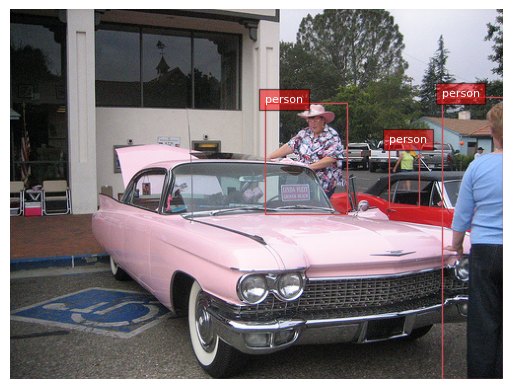

In [96]:
image = Image.open('archive/flickr30k_images/flickr30k_images/226630666.jpg')
# Run inference on a new image
results = best_model('archive/flickr30k_images/flickr30k_images/226630666.jpg')
bboxes, labels = get_bboxes_labels(results[0])
# Visualize the results for the current image
plot_bbox(image, bboxes, labels)


image 1/1 /content/archive/flickr30k_images/flickr30k_images/124972799.jpg: 384x512 2 pets, 276.1ms
Speed: 218.3ms preprocess, 276.1ms inference, 103.2ms postprocess per image at shape (1, 3, 384, 512)


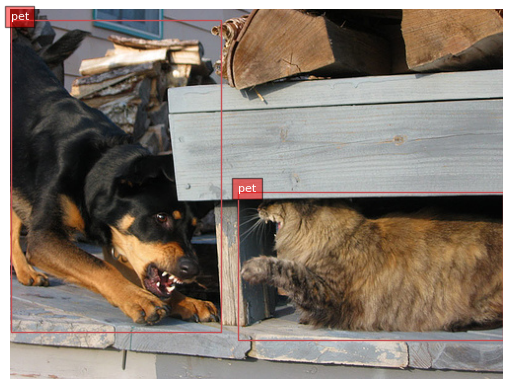

In [84]:
image = Image.open('archive/flickr30k_images/flickr30k_images/124972799.jpg')
# Run inference on a new image
results = best_model('archive/flickr30k_images/flickr30k_images/124972799.jpg')
bboxes, labels = get_bboxes_labels(results[0])
# Visualize the results for the current image
plot_bbox(image, bboxes, labels)


image 1/1 /content/archive/flickr30k_images/flickr30k_images/226456619.jpg: 512x352 1 person, 1 pet, 45.9ms
Speed: 46.5ms preprocess, 45.9ms inference, 10.1ms postprocess per image at shape (1, 3, 512, 352)


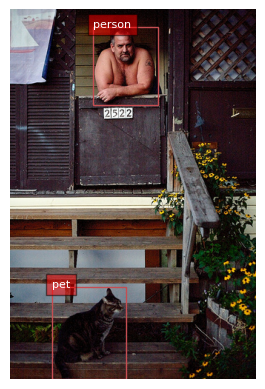

In [93]:
image = Image.open('archive/flickr30k_images/flickr30k_images/226456619.jpg')
# Run inference on a new image
results = best_model('archive/flickr30k_images/flickr30k_images/226456619.jpg')
bboxes, labels = get_bboxes_labels(results[0])
# Visualize the results for the current image
plot_bbox(image, bboxes, labels)


image 1/1 /content/archive/flickr30k_images/flickr30k_images/2312731013.jpg: 512x416 5 persons, 1 pet, 319.1ms
Speed: 333.9ms preprocess, 319.1ms inference, 100.8ms postprocess per image at shape (1, 3, 512, 416)


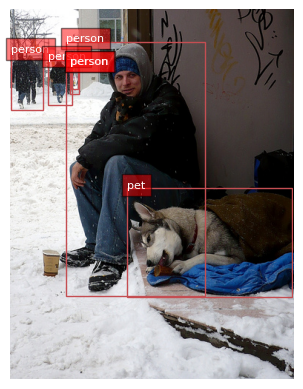

In [97]:
image = Image.open('archive/flickr30k_images/flickr30k_images/2312731013.jpg')
# Run inference on a new image
results = best_model('archive/flickr30k_images/flickr30k_images/2312731013.jpg')
bboxes, labels = get_bboxes_labels(results[0])
# Visualize the results for the current image
plot_bbox(image, bboxes, labels)